In [1]:
import networkx as nx
import pickle
import numpy as np
import json
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from collections import Counter
import re
import pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
%config InlineBackend.figure_format = 'retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 100
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'


CUSTOM_FORMAT = {"font_size": 8,
                "node_size": 80, "node_color": "#ff0000", "edgecolors": "#911a07",
                "width": 0.4, "edge_color": "black"}
import igraph as ig

In [3]:
### Cargo el json con la informacion de cada paquete, y el grafo

filename = '../../state_files/proc_jsons.json'
with open(filename, 'r') as f:
    pkg_json = json.load(f)

### Re-formateo el la lista de diccionarios por un diccionario de diccionarios, 
### con el nombre del paquete (nodo) de llave para la informacion.
info_dict = {}
for package in pkg_json:
    info_dict[package.pop('Name')] = package

# G = nx.read_gexf('../PyPi Network.gexf')
# G_ig = ig.Graph.from_networkx(G)

# Limpiado del DF

## Formateo las columnas del DataFrame, y limpio los Nones

In [4]:
df = pd.DataFrame(info_dict)
df = df.T

In [5]:
@np.vectorize
def format_strings(s: str):
    """
    Aplico un formato unificado para los paquetes.
    Esta funcion es importante porque las dependencias en varios de los paquetes
    aparecen con un formato distinto al nombre de las librerias (por ej. Numpy 
    es la libreria, y en las dependencias puede aparecer como NumPy, numpy, numpy[1.02], etc)

    """
    fmt_string = s.lower() # Normalizo todo a minuscula
    fmt_string = re.sub(r'[\_\-\| .,/\\;:=~]', '-', fmt_string) # Unifico separadores
    fmt_string = re.sub(r'\(\[\{', '[', fmt_string) # Unifico parentesis
    fmt_string = re.sub(r'\)\]\}', ']', fmt_string) # IDEM
    return fmt_string

In [6]:
# Normalizo a minuscula los nombres de los paquetes.
new_ix = format_strings(np.array(df.index))
df = df.rename(index={old_name: new_name for old_name, new_name in zip(df.index, new_ix)})

In [7]:
### Remplazo strings que indican elemento faltante por None
to_replace = ['', 'UNKNOWN', 'none', 'None', 'empty', 'nothing', np.nan, 'NaN', 'nan']
df.replace(to_replace, None, inplace=True)

### Remplazo los nones en dependencies por listas vacias
df.Dependencies = df.Dependencies.apply(lambda x: [] if x == None else x)

In [8]:
print(f'Number of packages: {len(df)}')

for column in ['Tags', 'Licence', 'Python Version']:
    print(f'NaN count {column} = {sum(df[column].isna())}')

### para el resto de las columnas, reviso cuantas tienen listas vacias
for column in ['Dependencies', 'Package Version', 'Classifiers']:
    print(f'NaN count {column} = {sum(~df[column].astype(bool))}')

Number of packages: 398843
NaN count Tags = 262638
NaN count Licence = 142794
NaN count Python Version = 252357
NaN count Dependencies = 228134
NaN count Package Version = 0
NaN count Classifiers = 99754


Descarto los paquetes que tienen 0 dependencias y dependen de 0 paquetes

In [9]:
@np.vectorize
def format_dependencies(s: str):
    """
    Formateo cosas particulares que aparecen en las dependencias.
    """

    fmt_string = re.sub(r'\[.*\]', '', s) # Le quito la parte entre corchetes
    fmt_string = fmt_string.rstrip('-') # Le quito la - del final
    
    return fmt_string

In [10]:
df['Dependencies'] = df['Dependencies'].apply(lambda x: list(format_strings(x)) if 
                                              np.logical_and(type(x) == list, bool(x)) else x)
df['Dependencies'] = df['Dependencies'].apply(lambda x: list(format_dependencies(x)) if
                                              np.logical_and(type(x) == list, bool(x)) else x)

### Le quito posibles dependencias repetidas
df['Dependencies'] = df['Dependencies'].apply(lambda x: list(set(x)))

Quito autoenlaces

In [11]:
def remove_self_edges(x):
    """
    Quita dependencias de paquetes con sigo mismo.
    """
    
    dependencies = x.Dependencies.copy()
    while x.name in dependencies:
        dependencies.remove(x.name)
        x['Dependencies'] = dependencies
    return x

In [12]:
df = df.apply(remove_self_edges, axis=1)

Agrego columnas de dependencias, y quito nodos sin enlaces entrantes ni salientes

In [13]:
dep_pakage_counter = []
for dep in df['Dependencies']:
    if np.logical_and(type(dep) == list, bool(dep)):
        dep_pakage_counter += dep 

dep_pakage_counter = Counter(dep_pakage_counter)
dep_pakage_counter = dict(sorted(dep_pakage_counter.items(), key=lambda x: x[1], reverse=True))

In [14]:
# saco los paquetes que no estan indexados en el dataframe (los guarde como 'packages_not_found.txt')
packages_not_found = set(dep_pakage_counter.keys()) - set(df.index)
dep_pakage_counter = {k: i for k, i in dep_pakage_counter.items() if k in df.index}

In [15]:
# Creo la columna de la cantidad de librerias que dependen de cada lib, y la relleno con lo que obtuvimos recien
df['Dependant Libraries Count'] = np.zeros(len(df))
df.loc[dep_pakage_counter.keys(), 'Dependant Libraries Count'] = list(dep_pakage_counter.values())

Modifico las dependencias quitandole las librerias que no estan como indices en el DF

In [16]:
def clean_dependencies(deps):
    global packages_not_found
    
    ret = deps
    deps_not_found = list(set(packages_not_found) & set(deps))
    
    if bool(deps_not_found):
        for dnf in deps_not_found:
            ret.remove(dnf)
    return ret


In [17]:
df['Dependencies'] = df['Dependencies'].apply(clean_dependencies)

Quito librerias sin enlaces

In [18]:
df = df[np.logical_or(df['Dependant Libraries Count'] > 0, df['Dependencies'].astype(bool))]

# Classifiers

Primero, observo que los classifiers pueden tener como maximo 5 elementos [grupo, subgrupo, ..., subsubsubsubgrupo]

In [20]:
def format_classifiers(classifiers, column):
    
    # Si es None o una lista vacia, devuelvo None
    if bool(classifiers) == False:
        ret = None

    else:
        x = []
        for c in classifiers:
            split_classifier = c.split(' :: ')

            if split_classifier[0] == column:
                # x = c.replace(split_classifier[0] + ' :: ',  '')
                x.append(split_classifier[1]) ### OJO que aca estaria perdiendo las subcategorias...
        
        # Si no hay coincidencias, devuelvo None
        if bool(x) == False:
            ret = None
        
        else:
            ret = ''
            x = sorted(set(x))
            for element in x:
                ret += element
                ret += ' - '
            ret = ret.rstrip(' - ')

    return ret

In [21]:
### Armo la lista de topicos de 1er nivel (los que aparecen antes del ' :: ')

topics = []
for classifiers in tqdm(df['Classifiers']):
    if bool(classifiers) == False:
        pass
    else: 
        for c in classifiers:
            split_classifier = c.split(' :: ')
            topics.append(split_classifier[0])

topics = set(topics)

100%|██████████| 185314/185314 [00:00<00:00, 294926.20it/s]


In [22]:
# Creo una columna para cada classifier.
# OJO que me estoy quedando solo con la categoria a primer orden, ignorando las sub-categorias

for topic in tqdm(topics):
    df[topic] = df['Classifiers'].apply(format_classifiers, column=topic)

100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


## Programming language

Notese que aunque hayan varios paquetes que tienen bajo "programming language" otro lenguaje que no es python, la gran mayoria tiene al menos una version de python anotada.

Para estos ~60 casos, descartamos los nodos.

In [23]:
# descarto las librerias que no tienen a python como uno de sus languages (las que no especifican, las dejo)
df = df[np.logical_or(df['Programming Language'].isnull(), df['Programming Language'].str.contains('Python'))]

## Gráfico de tópicos

In [24]:
def format_topics(topics):
    # Si es None o una lista vacia, devuelvo None
    if bool(topics) == False:
        topic_list = None

    else:
        topic_list = sorted(topics.split(' - '))
    return topic_list

In [25]:
df['Topic'] = df['Topic'].apply(format_topics)

In [26]:
topics_all = [] # Lista que va a contar los topicos de todas las librerias
for topics in tqdm(df['Topic']):
    if bool(topics):
        topics_all += topics

topics_all = dict(Counter(topics_all))
topics_all = dict(sorted(topics_all.items(), key=lambda x: x[1], reverse=True))

100%|██████████| 185242/185242 [00:00<00:00, 1643698.02it/s]


In [27]:
def plot_pie_chart(counter_dict, thresh_for_others=0, include_others=True):

    dict_all_toplot = {k: v for k, v in counter_dict.items() if v > thresh_for_others}
    
    if include_others:
        dict_all_toplot['Others'] = sum([v for v in counter_dict.values() if v < thresh_for_others])

    patches, labels, pct_texts = plt.pie(dict_all_toplot.values(),
                                        labels=dict_all_toplot.keys(), rotatelabels=90, 
                                        startangle=180, 
                                        autopct=lambda p: f"{p:.2f}%  ({p * sum(dict_all_toplot.values()) / 100:.0f})",
                                        textprops={'fontsize': 8})

    for label, pct_text in zip(labels, pct_texts):
        pct_text.set_rotation(label.get_rotation())
        pct_text.set_fontsize(6)
    plt.show()

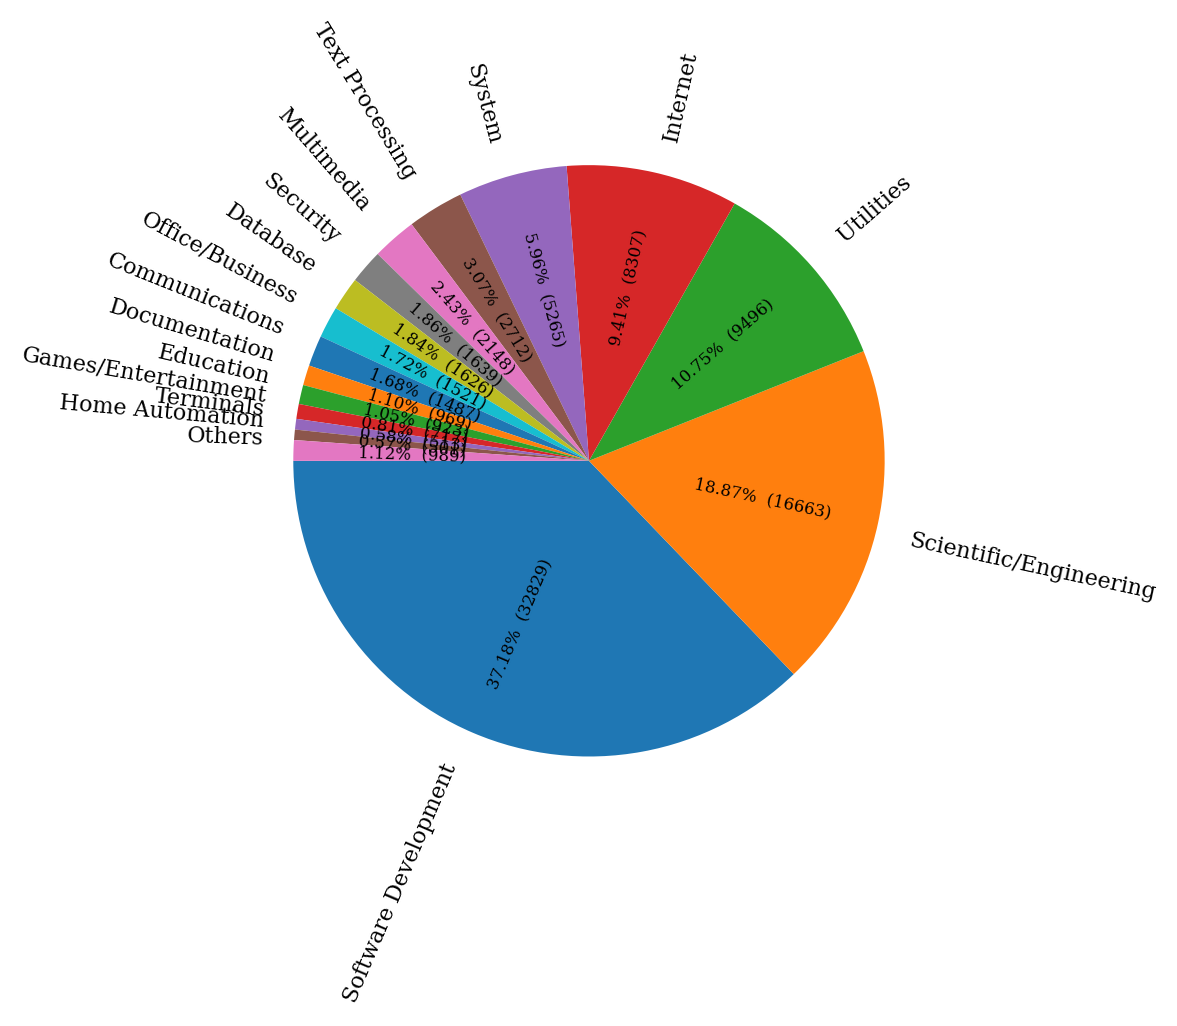

In [28]:
thresh = 500
plot_pie_chart(topics_all, thresh_for_others=500)

## Intended Audience

Despues deberia armar una funcion que haga esto, porque estoy repitiendo lo que hice antes

In [29]:
df['Intended Audience'] = df['Intended Audience'].apply(format_topics)

In [30]:
intended_audience_all = [] # Lista que va a contar los topicos de todas las librerias
for intended_audience in tqdm(df['Intended Audience']):
    if bool(intended_audience):
        intended_audience_all += intended_audience

intended_audience_all = dict(Counter(intended_audience_all))
intended_audience_all = dict(sorted(intended_audience_all.items(), key=lambda x: x[1], reverse=True))

100%|██████████| 185242/185242 [00:00<00:00, 2086950.57it/s]


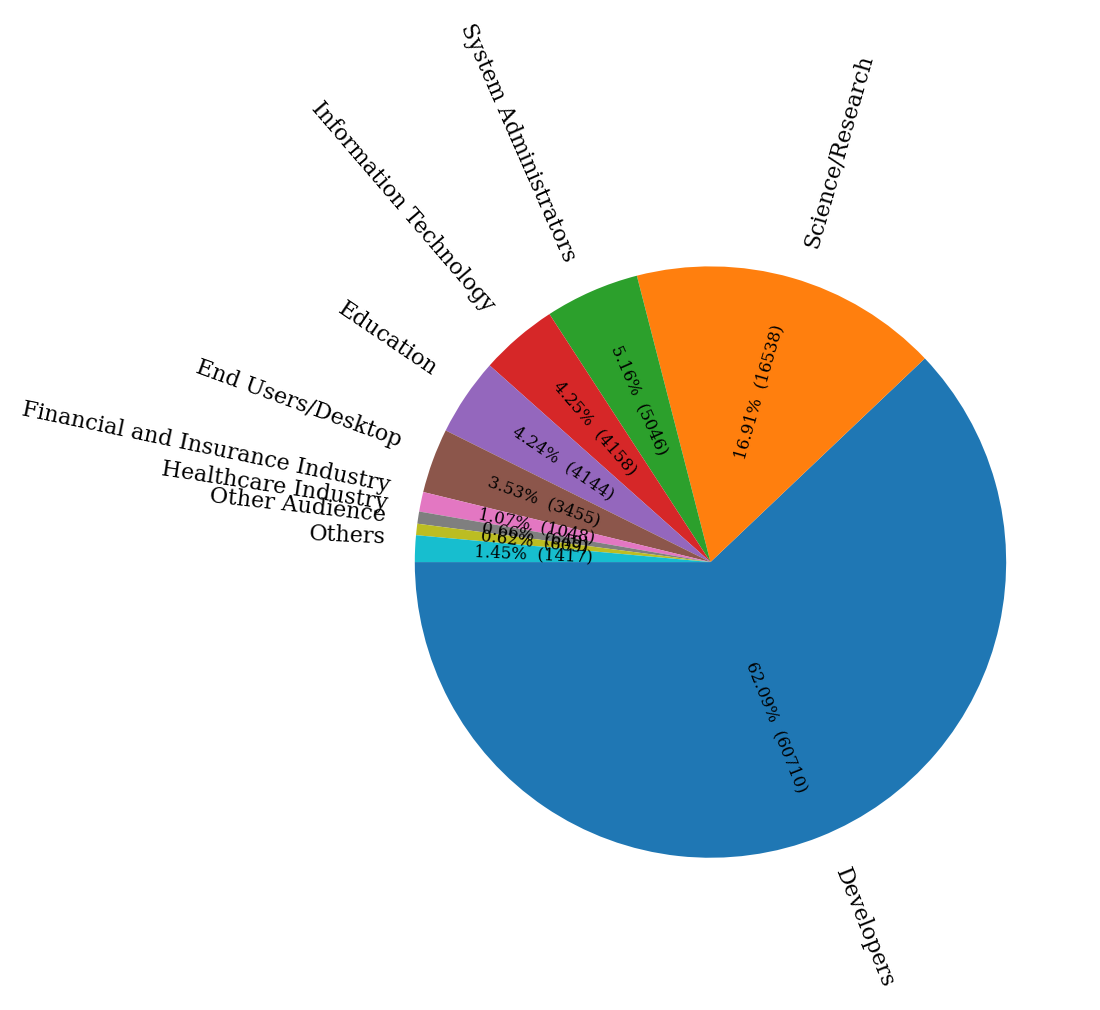

In [31]:
plot_pie_chart(intended_audience_all, thresh_for_others=510)

In [32]:
df['Dependencies count'] = df['Dependencies'].apply(lambda x: len(x) if type(x) is list else 0)

In [33]:
dependencies_count = {k: v for k, v in df['Dependencies count'].items()}
dependencies_count = dict(sorted(dependencies_count.items(), key=lambda x: x[1], reverse=True))

In [34]:
print('librerias con mas dependencias:\n')
print(list(dependencies_count.items())[:10])

librerias con mas dependencias:

[('ai-python', 453), ('apache-airflow', 370), ('custom-workflow-solutions', 331), ('boto3-stubs-lite', 321), ('boto3-stubs', 321), ('types-aiobotocore-lite', 316), ('types-aiobotocore', 316), ('bitfount', 306), ('types-aioboto3-lite', 304), ('types-aioboto3', 304)]


# Guardado de archivos: Grafo y Dataframe

In [35]:
with open('PyPi Dataframe V4.df', 'wb') as f:
    pickle.dump(df, f)

In [36]:
edges = []
nodes = [n for n in df.index]

for node in nodes:
    dependencies = df.loc[node, 'Dependencies']
    
    if np.logical_and(type(dependencies) == list, bool(dependencies)):
        node_edges = [(dep, node) for dep in dependencies]
        edges += node_edges

In [37]:
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [38]:
nx.write_gexf(G, 'PyPi Network V4.gexf')